In [1]:
!pip install ultralytics


In [2]:
from ultralytics import YOLO

model = YOLO('./weights/v5_30.pt')

In [3]:
# pip cv2

In [4]:
import cv2

image_path1 = './test/IMG_3969.JPG'  
image_path2 = './test/IMG_3968.JPG' 

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
result1 = model.predict(source=image1, conf=0.85)  
result2 = model.predict(source=image2, conf=0.85)


for result in result1:
    boxes = result.boxes 
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]  
        conf = box.conf[0]  
        cls = box.cls[0]  

        cv2.rectangle(image1, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(image1, f'Class: {int(cls)}, Conf: {conf:.2f}', 
                    (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


for result in result2:
    boxes = result.boxes  
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0] 
        conf = box.conf[0]  
        cls = box.cls[0] 

        cv2.rectangle(image2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(image2, f'Class: {int(cls)}, Conf: {conf:.2f}', 
                    (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


0: 640x480 1 cargo, 126.9ms
Speed: 3.0ms preprocess, 126.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 cargo, 105.9ms
Speed: 5.0ms preprocess, 105.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)


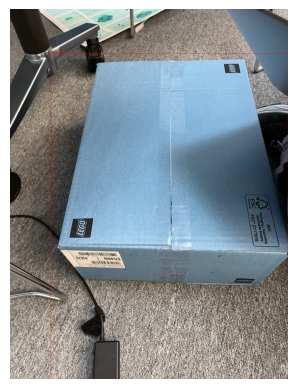

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image1)
plt.axis('off')
plt.show()

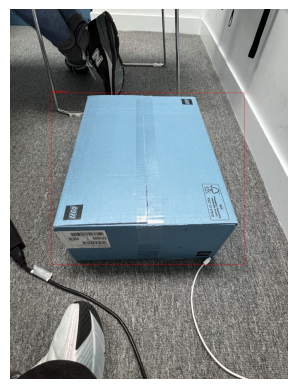

In [6]:
plt.imshow(image2)
plt.axis('off')
plt.show()


0: 640x480 (no detections), 145.9ms
Speed: 2.6ms preprocess, 145.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)


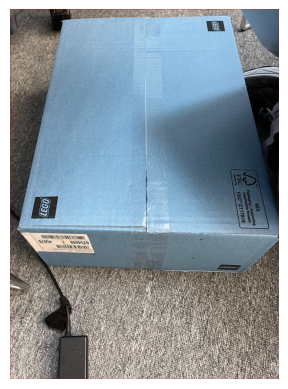

In [7]:
results = model.predict(source=image1, conf=0.85)  

for result in result1:
    boxes = result.boxes  
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]  
cropped_image1 = image1[int(y1):int(y2), int(x1):int(x2)] 


plt.imshow(cropped_image1)
plt.axis('off')
plt.show()


In [8]:
output_path = './test/cropped_image1.jpg' 
cv2.imwrite(output_path, cropped_image1)

True


0: 640x480 1 cargo, 117.2ms
Speed: 2.3ms preprocess, 117.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


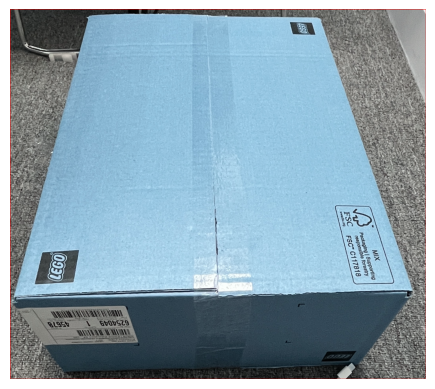

In [9]:
results = model.predict(source=image2, conf=0.85)  

for result in result2:
    boxes = result.boxes  
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]  
cropped_image2 = image2[int(y1):int(y2), int(x1):int(x2)] 


plt.imshow(cropped_image2)
plt.axis('off')
plt.show()


In [10]:
output_path = './test/cropped_image2.jpg' 
cv2.imwrite(output_path, cropped_image2)

True

In [11]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm
import numpy as np

# Load the pre-trained model
base_model = VGG16(weights='imagenet')

# Create a new model that outputs the last layer of features
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def get_embeddings(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize image to 224x224
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    # Get the embeddings
    embedding = model.predict(image)
    return embedding

# Get embeddings for two images
embedding1 = get_embeddings('./test/cropped_image1.jpg')
embedding2 = get_embeddings('./test/cropped_image2.jpg')


# 計算餘弦相似度
embedding1_flat = embedding1.flatten()  # (4096,)
embedding2_flat = embedding2.flatten() 

cosine_similarity = dot(embedding1_flat, embedding2_flat) / (norm(embedding1_flat) * norm(embedding2_flat))
print(f"Cosine Similarity: {cosine_similarity:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Cosine Similarity: 0.6703


In [12]:
from ultralytics import YOLO
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm
import numpy as np

In [13]:
def crop(image, model):
    results = model.predict(source=image, conf=0.85)  
    for result in results:
        boxes = result.boxes 
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]  
    cropped_image = image[int(y1):int(y2), int(x1):int(x2)] 
    return cropped_image

In [14]:
def embed(image,model):
    image = cv2.resize(image, (224, 224))  # Resize image to 224x224
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    embedding = model.predict(image).flatten()
    return embedding

In [15]:
def cos_sim(embed1, embed2):
    cosine_similarity = dot(embed1, embed2) / (norm(embed1) * norm(embed2))
    return cosine_similarity

In [16]:
def main():
    model = YOLO('./weights/v5_30.pt')
    base_model = VGG16(weights='imagenet')
    embed_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

    image_path1 = './test/IMG_3969.JPG'  
    image_path2 = './test/IMG_3968.JPG' 
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)
    cos_similarity = cos_sim(embed(crop(image1,model),embed_model), embed(crop(image2,model),embed_model))
    print(cos_similarity)

In [17]:
main()


0: 640x480 1 cargo, 147.8ms
Speed: 4.1ms preprocess, 147.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 480)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step

0: 640x480 1 cargo, 104.3ms
Speed: 1.9ms preprocess, 104.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
0.67509097
